<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
مقایسه منحنی ROC مدل‌ها
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در این نوتبوک، منحنی <b>ROC (Receiver Operating Characteristic)</b> را برای تمام مدل‌های آموزش‌دیده رسم می‌کنیم.
<br>
منحنی ROC نشان‌دهنده Trade-off بین <b>True Positive Rate</b> و <b>False Positive Rate</b> در آستانه‌های مختلف تصمیم‌گیری است.
<br>
معیار <b>AUC (Area Under Curve)</b> نشان‌دهنده توانایی کلی مدل در تفکیک کلاس‌ها است؛ هرچه به ۱ نزدیک‌تر باشد، مدل بهتر عمل می‌کند.
</font>
</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۱) خواندن داده و تقسیم‌بندی
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
از همان داده پیش‌پردازش‌شده و همان <code>random_state=42</code> استفاده می‌کنیم تا تقسیم‌بندی Train/Validation دقیقاً مشابه سایر نوتبوک‌ها باشد و نتایج قابل مقایسه باشند.
</font>
</p>

In [3]:
train_data = pd.read_csv("../../data/train_processed.csv")

X = train_data.drop(columns=["TripReason"])
y = train_data["TripReason"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (80304, 17) Val: (20076, 17)


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۲) تعریف مدل‌ها با بهترین پارامترها
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
هر مدل با بهترین پارامترهایی که در نوتبوک مربوطه پیدا شده، ساخته می‌شود.
<br>
<b>نکته مهم:</b> برای SVM از <code>probability=True</code> استفاده می‌کنیم تا بتوانیم احتمال پیش‌بینی را به دست آوریم.
</font>
</p>

In [4]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", LogisticRegression(C=1, penalty="l2", solver="lbfgs", max_iter=5000))
    ]),

    "KNN (k=29)": Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsClassifier(n_neighbors=29, weights="distance", metric="minkowski", p=1))
    ]),

    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1
    ),

    # "SVM (RBF)": Pipeline([
    #     ("scaler", MinMaxScaler()),
    #     ("model", SVC(kernel="rbf", C=10, gamma="scale", probability=True))
    # ]),
}

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۳) آموزش مدل‌ها و محاسبه احتمال پیش‌بینی
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای رسم منحنی ROC به احتمال تعلق هر نمونه به کلاس مثبت (<code>predict_proba</code>) نیاز داریم.
<br>
هر مدل روی داده Train آموزش می‌بیند و سپس احتمال پیش‌بینی روی Validation محاسبه می‌شود.
</font>
</p>

In [5]:
roc_data = {}

for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(X_train, y_train)

    # get probability for positive class (Work = 1)
    y_prob = model.predict_proba(X_val)[:, 1]

    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)

    roc_data[name] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc}
    print(f"  AUC = {roc_auc:.4f}")

print("\nDone.")

Training Logistic Regression ...


/home/matltin/Project/python/AI-FinalProject-Billitio-ML/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


  AUC = 0.8299
Training KNN (k=29) ...
  AUC = 0.8968
Training Random Forest ...
  AUC = 0.9044
Training XGBoost ...
  AUC = 0.8963

Done.


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۴) رسم منحنی ROC برای همه مدل‌ها
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
تمام منحنی‌ها در یک نمودار رسم می‌شوند تا مقایسه دیداری آسان باشد.
<br>
خط چین قرمز نشان‌دهنده مدل تصادفی (Random Classifier) با AUC=0.5 است.
</font>
</p>

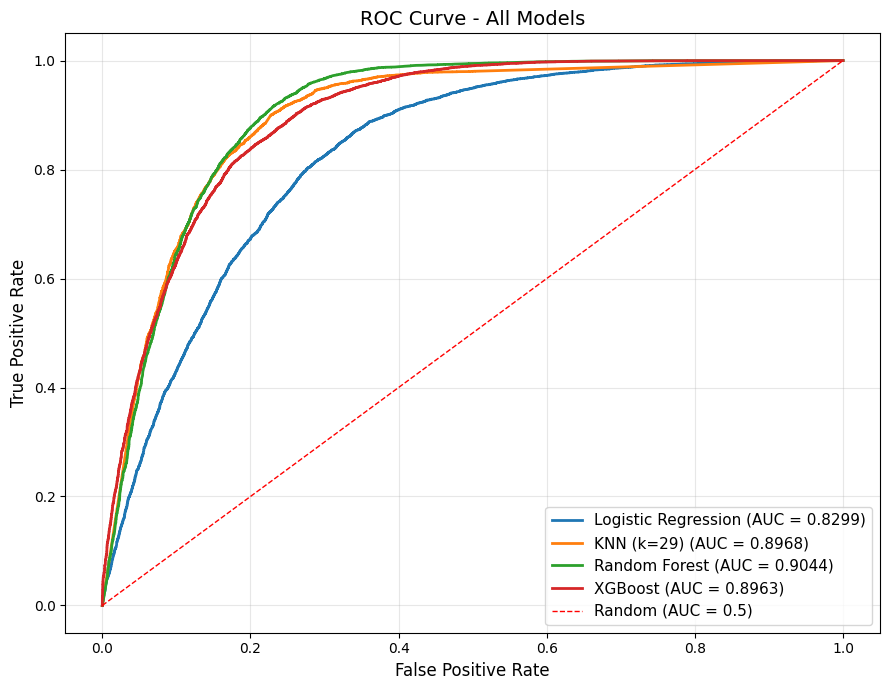

Saved to artifacts/roc_curves.png


In [6]:
plt.figure(figsize=(9, 7))

for name, data in roc_data.items():
    plt.plot(data["fpr"], data["tpr"], linewidth=2,
             label=f"{name} (AUC = {data['auc']:.4f})")

plt.plot([0, 1], [0, 1], "r--", linewidth=1, label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve - All Models", fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../../artifacts/roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved to artifacts/roc_curves.png")

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۵) جدول مقایسه AUC مدل‌ها
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای مقایسه عددی، مقدار AUC هر مدل در یک جدول نمایش داده می‌شود.
</font>
</p>

In [7]:
auc_table = pd.DataFrame([
    {"Model": name, "AUC": f"{data['auc']:.4f}"}
    for name, data in roc_data.items()
]).sort_values("AUC", ascending=False).reset_index(drop=True)

auc_table

,Model,AUC
0,Random Forest,0.9044
1,KNN (k=29),0.8968
2,XGBoost,0.8963
3,Logistic Regression,0.8299
